# Construction Site Safety Hardhat Detection Progress Report  
  
**Team 18**  
Member： Aiden Fallah, Manraj Shergill, Li Qi, Erich (Yue) YU

## Introduction


Ensuring the safety of workers on construction sites is paramount, with the proper use of Personal Protective Equipment (PPE) such as hardhats serving as a critical component in preventing workplace injuries and fatalities. However, manual monitoring of PPE compliance can be labor-intensive and prone to human error. To address this challenge, this project focuses on the development of an automated system for detecting whether workers are wearing appropriate PPE, specifically hardhats, using advanced computer vision techniques.

Three different models were evaluated to achieve this objective: a fine tuned YOLO model, Faster R-CNN, and a standard CNN. Among these, the YOLOv8 model demonstrated superior performance in accurately identifying hardhats and in a much faster speed, followed by Faster R-CNN and CNN respectively. The comparative analysis highlights the effectiveness of real-time object detection algorithms in enhancing safety protocols on construction sites, paving the way for more reliable and efficient PPE compliance monitoring systems.

## Dataset Introduction

The [Construction Site Safety Image Dataset Roboflow](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/data) is a comprehensive and beginner-friendly collection designed to enhance worker safety monitoring on construction sites. Hosted on Roboflow, this dataset is formatted in YOLOv8, facilitating tasks such as multi-class classification, object detection, and tracking. It comprises 10 distinct classes, including various Personal Protective Equipment (PPE) categories like 'Hardhat', 'Mask', and 'Safety Vest', as well as non-compliance labels such as 'NO-Hardhat' and 'NO-Mask'. Additionally, it includes classes for 'Person', 'Safety Cone', 'machinery', and 'vehicle', which are crucial for contextual awareness in safety applications.


#### Data Loading

In [6]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('snehilsanyal/construction-site-safety-image-dataset-roboflow', path='D:/Downloads/1517_dataset', unzip=True)

# print("Dataset downloaded and extracted!")

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:39<00:00, 62.3MB/s]

Extracting files...


Path to dataset files: C:\Users\Yu Yue\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [1]:
dataset_path = "C:\\Users\\Yu Yue\\Desktop\\MIE1517_project\\datasets\\paultimothymooney\\chest-xray-pneumonia\\versions\\2\\chest_xray" 

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),# [batch, 256, 14, 14]
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), # [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, 224, 224]
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define paths
dataset_path = "C:/Users/Yu Yue/Desktop/MIE1517_project/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Ensure images are grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),    # Convert to Tensor
])

# Load the training dataset (only Normal images)
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)

# Filter only Normal class (assuming class 0 is Normal)
normal_class = 0  # Check with train_dataset.class_to_idx
normal_indices = [i for i, (_, label) in enumerate(train_dataset) if label == normal_class]
train_subset = Subset(train_dataset, normal_indices)

# Validation and Test datasets
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform=transform)

# Data loaders
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [21]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training parameters
num_epochs = 50
best_val_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * img.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            val_loss += loss.item() * img.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')
        print("Model saved!")

Epoch 1/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Epoch [1/50], Train Loss: 0.0286, Val Loss: 0.0049
Model saved!


Epoch 2/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch [2/50], Train Loss: 0.0051, Val Loss: 0.0026
Model saved!


Epoch 3/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [3/50], Train Loss: 0.0037, Val Loss: 0.0022
Model saved!


Epoch 4/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch [4/50], Train Loss: 0.0034, Val Loss: 0.0019
Model saved!


Epoch 5/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [5/50], Train Loss: 0.0028, Val Loss: 0.0017
Model saved!


Epoch 6/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Epoch [6/50], Train Loss: 0.0027, Val Loss: 0.0016
Model saved!


Epoch 7/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch [7/50], Train Loss: 0.0027, Val Loss: 0.0016
Model saved!


Epoch 8/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Epoch [8/50], Train Loss: 0.0023, Val Loss: 0.0015
Model saved!


Epoch 9/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch [9/50], Train Loss: 0.0021, Val Loss: 0.0013
Model saved!


Epoch 10/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [10/50], Train Loss: 0.0020, Val Loss: 0.0012
Model saved!


Epoch 11/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [11/50], Train Loss: 0.0018, Val Loss: 0.0012
Model saved!


Epoch 12/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [12/50], Train Loss: 0.0023, Val Loss: 0.0014


Epoch 13/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Epoch [13/50], Train Loss: 0.0017, Val Loss: 0.0010
Model saved!


Epoch 14/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Epoch [14/50], Train Loss: 0.0014, Val Loss: 0.0010
Model saved!


Epoch 15/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch [15/50], Train Loss: 0.0015, Val Loss: 0.0010
Model saved!


Epoch 16/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [16/50], Train Loss: 0.0013, Val Loss: 0.0009
Model saved!


Epoch 17/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch [17/50], Train Loss: 0.0013, Val Loss: 0.0009
Model saved!


Epoch 18/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [18/50], Train Loss: 0.0013, Val Loss: 0.0009
Model saved!


Epoch 19/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [19/50], Train Loss: 0.0014, Val Loss: 0.0009
Model saved!


Epoch 20/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [20/50], Train Loss: 0.0013, Val Loss: 0.0009
Model saved!


Epoch 21/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [21/50], Train Loss: 0.0013, Val Loss: 0.0010


Epoch 22/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch [22/50], Train Loss: 0.0012, Val Loss: 0.0008
Model saved!


Epoch 23/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch [23/50], Train Loss: 0.0012, Val Loss: 0.0008


Epoch 24/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Epoch [24/50], Train Loss: 0.0012, Val Loss: 0.0008
Model saved!


Epoch 25/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [25/50], Train Loss: 0.0011, Val Loss: 0.0009


Epoch 26/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Epoch [26/50], Train Loss: 0.0011, Val Loss: 0.0009


Epoch 27/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch [27/50], Train Loss: 0.0011, Val Loss: 0.0008
Model saved!


Epoch 28/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [28/50], Train Loss: 0.0011, Val Loss: 0.0008
Model saved!


Epoch 29/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch [29/50], Train Loss: 0.0012, Val Loss: 0.0008


Epoch 30/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Epoch [30/50], Train Loss: 0.0011, Val Loss: 0.0008


Epoch 31/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [31/50], Train Loss: 0.0010, Val Loss: 0.0008
Model saved!


Epoch 32/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch [32/50], Train Loss: 0.0011, Val Loss: 0.0008
Model saved!


Epoch 33/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch [33/50], Train Loss: 0.0010, Val Loss: 0.0008
Model saved!


Epoch 34/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Epoch [34/50], Train Loss: 0.0013, Val Loss: 0.0008


Epoch 35/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Epoch [35/50], Train Loss: 0.0010, Val Loss: 0.0008
Model saved!


Epoch 36/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [36/50], Train Loss: 0.0011, Val Loss: 0.0008


Epoch 37/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch [37/50], Train Loss: 0.0010, Val Loss: 0.0008


Epoch 38/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Epoch [38/50], Train Loss: 0.0011, Val Loss: 0.0009


Epoch 39/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Epoch [39/50], Train Loss: 0.0010, Val Loss: 0.0007
Model saved!


Epoch 40/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch [40/50], Train Loss: 0.0011, Val Loss: 0.0007


Epoch 41/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch [41/50], Train Loss: 0.0010, Val Loss: 0.0008


Epoch 42/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Epoch [42/50], Train Loss: 0.0009, Val Loss: 0.0007
Model saved!


Epoch 43/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [43/50], Train Loss: 0.0010, Val Loss: 0.0007


Epoch 44/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Epoch [44/50], Train Loss: 0.0009, Val Loss: 0.0007
Model saved!


Epoch 45/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Epoch [45/50], Train Loss: 0.0010, Val Loss: 0.0007
Model saved!


Epoch 46/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [46/50], Train Loss: 0.0009, Val Loss: 0.0007


Epoch 47/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch [47/50], Train Loss: 0.0010, Val Loss: 0.0008


Epoch 48/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch [48/50], Train Loss: 0.0009, Val Loss: 0.0009


Epoch 49/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch [49/50], Train Loss: 0.0009, Val Loss: 0.0016


Epoch 50/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

Epoch [50/50], Train Loss: 0.0010, Val Loss: 0.0007
Model saved!


In [22]:
# Load the best model
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()

C:\Users\Yu Yue\AppData\Local\Temp\ipykernel_37116\6902249.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_autoencoder.pth'))


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
 

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

reconstruction_errors = []
labels = []

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        img, label = data
        img = img.to(device)
        output = model(img)
        loss = F.mse_loss(output, img, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())
        labels.extend(label.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
labels = np.array(labels)

Testing: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


ROC AUC: 0.3106


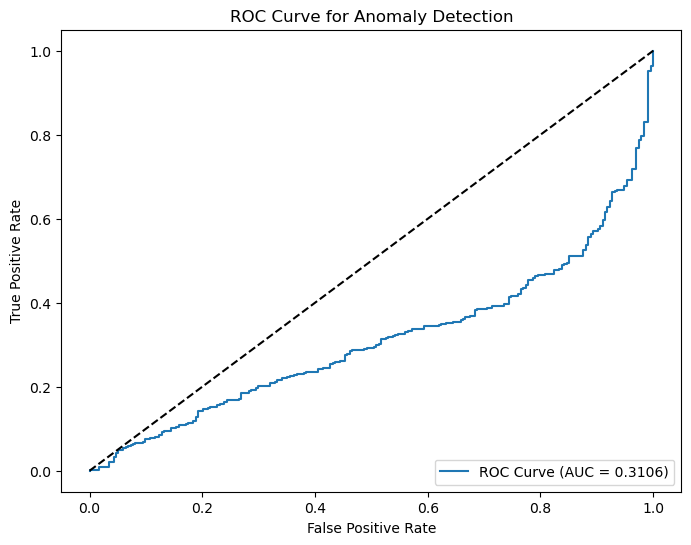

Optimal Threshold: 0.0019


In [24]:
# Compute ROC AUC
auc = roc_auc_score(labels, reconstruction_errors)
print(f"ROC AUC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(labels, reconstruction_errors)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.show()

# Select threshold (e.g., where TPR - FPR is maximum)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict labels based on threshold
preds = (reconstruction_errors > optimal_threshold).astype(int)  # 1: Anomaly (Pneumonia), 0: Normal

# Compute metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.3750
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


d:\Environment\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')

# Get some test samples
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
outputs = model(images)

# Move to CPU for visualization
images = images.cpu()
outputs = outputs.cpu()

# Compute reconstruction error for each image
errors = F.mse_loss(outputs, images, reduction='none').view(images.size(0), -1).mean(dim=1).numpy()

# Display images with their reconstruction errors
plt.figure(figsize=(12, 6))
for idx in range(8):
    plt.subplot(4, 4, 2*idx+1)
    imshow(images[idx], title=f"Original\nLabel: {'Pneumonia' if labels[idx]==1 else 'Normal'}")
    plt.subplot(4, 4, 2*idx+2)
    imshow(outputs[idx], title=f"Reconstructed\nError: {errors[idx]:.4f}")
plt.tight_layout()
plt.show()

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'